# This is for waltzdb

In [3]:
import mlflow
import matplotlib.pyplot as plt
from mlflow import MlflowClient
from mlflow.entities import ViewType
import pandas as pd
import pprint
import json
import ast
import sys
sys.path.insert(0, '/novo/projects/departments/cdd/public/users/ehec/au24/ML-BP-Domino')

from omegaconf import OmegaConf
import seaborn as sns
import lacroix
from sklearn.decomposition import PCA

from pathlib import Path
from hydra import compose, initialize, initialize_config_dir
from src.helpers.dataset import CSVDataLoader
from src.model.composite_model import CompositeModel
from torch.nn.utils.rnn import pad_sequence
import matplotlib.gridspec as gridspec

import torch
from sklearn.metrics import matthews_corrcoef
from src.helpers.pytorch.light_attention import LightAttentionModule
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
import os

2025-06-08 21:13:07.746810: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-08 21:13:07.750146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-08 21:13:08.070635: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 21:13:08.667712: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-08 21:13:19.756603: W tensorflow/compiler/tf2

In [4]:
waltzpadded = pd.read_csv('/novo/projects/departments/cdd/molecular_ai/mlbp/data/fibrillation_data/sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test_randpadded10x_padlen-10.csv')
waltzneg = pd.read_csv('/novo/projects/departments/cdd/molecular_ai/mlbp/data/fibrillation_data/sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test_waltznegativeaapadded10x_padlen-10.csv')
waltztruerand = pd.read_csv('/novo/projects/departments/cdd/molecular_ai/mlbp/data/fibrillation_data/sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test_TRUErandpadded10x_padlen-10.csv')
waltz5 =pd.read_csv('/novo/projects/departments/cdd/molecular_ai/mlbp/data/fibrillation_data/sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test_randpadded10x_padlen-5.csv')
waltz20 = pd.read_csv('/novo/projects/departments/cdd/molecular_ai/mlbp/data/fibrillation_data/sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test_randpadded10x_padlen-20.csv')

In [5]:
waltzpadded = waltzpadded[waltzpadded['data_split_fold4'] == 'val']
waltzpadded['data_split_fold4'] = 'test'

waltzneg = waltzneg[waltzneg['data_split_fold4'] == 'val']
waltzneg['data_split_fold4'] = 'test'

waltztruerand = waltztruerand[waltztruerand['data_split_fold4'] == 'val']
waltztruerand['data_split_fold4'] = 'test'

waltz5 = waltz5[waltz5['data_split_fold4'] == 'val']
waltz5['data_split_fold4'] = 'test'

waltz20 = waltz20[waltz20['data_split_fold4'] == 'val']
waltz20['data_split_fold4'] = 'test'

names = ['PALM']*2800 + ['negative']*2800 + ['truerand']*2800 + ['pad5']*2800 + ['pad20']*2800

len(waltzpadded), len(waltzneg), len(waltztruerand), len(waltz5), len(waltz20)

(2800, 2800, 2800, 2800, 2800)

In [6]:
def multiply_elements(row):
    return ''.join(['1' if row['value_bool'] == 1 and char == '1' else '0' for char in row['mask']])
    
waltzpadded['res_labels'] = waltzpadded.apply(multiply_elements, axis=1)
waltzneg['res_labels'] = waltzneg.apply(multiply_elements, axis=1)
waltztruerand['res_labels'] = waltztruerand.apply(multiply_elements, axis=1)
waltz5['res_labels'] = waltz5.apply(multiply_elements, axis=1)
waltz20['res_labels'] = waltz20.apply(multiply_elements, axis=1)

In [7]:
results = []
results_name = []
results_padid = []
results_resid = []

In [8]:
cfg_name = ["esm2t68MUR50D_LightAttention_sbxwfibrillationpeptidewaltzdb-5foldtrain-valserrano-testrandpadded10xpadlen-10",
           'esm2t68MUR50D_LightAttention_sbxwfibrillationpeptidewaltzdb-5foldtrain-valserrano-testwaltznegativeaapadded10xpadlen-10',
           'esm2t68MUR50D_LightAttention_sbxwfibrillationpeptidewaltzdb-5foldtrain-valserrano-testTRUErandpadded10xpadlen-10',
           'esm2t68MUR50D_LightAttention_sbxwfibrillationpeptidewaltzdb-5foldtrain-valserrano-testrandpadded10xpadlen-5',
           'esm2t68MUR50D_LightAttention_sbxwfibrillationpeptidewaltzdb-5foldtrain-valserrano-testrandpadded10xpadlen-20']
folders = ['plain_waltz_pad_best_model_4', '250519_padding/10x10neg_4', '250531_embedders/10xrandpad_4', '250519_padding/10x5_4', '250519_padding/10x20_4']

waltz_tmp = [waltzpadded, waltzneg, waltztruerand, waltz5, waltz20]
names = ['PALM (non-hydrophobic, 10aa)', 'WaltzDB non-amyloid', 'Random', 'Non-hydrophobic 5aa', 'Non-hydrophobic 20aa']

for idx,folder in enumerate(folders):
    pad_identity = [x for xs in list(waltz_tmp[idx]['mask']) for x in xs]
    res_identity = [x for xs in list(waltz_tmp[idx]['res_labels']) for x in xs]
    results_padid.extend(pad_identity)
    results_resid.extend(res_identity)
    
    config_path = f'/novo/projects/departments/cdd/public/users/ehec/au24/250317_models/{folder}'
    
    with initialize_config_dir(config_dir=config_path, version_base=None, job_name="test"):
        cfg = compose(config_name=cfg_name[idx],
                      overrides=[f"+general.composite_model_path={config_path}"])
        print(OmegaConf.to_yaml(cfg))
        model = CompositeModel(cfg)
    
    dataloader = CSVDataLoader(cfg, waltz_tmp[idx])
    predictions = model.forward(dataloader)
    
    output_numpy = model.predictor.model.o_unflattened.cpu().numpy()
    mask = pad_sequence([torch.ones(len(seq)) for seq in waltz_tmp[idx].sequence], batch_first=True)
    mask_numpy = ~mask.cpu().numpy().astype(bool)
    output_numpy = np.ma.masked_array(output_numpy,mask_numpy)
    results.extend(list(np.array(output_numpy.compressed())))
    results_name.extend(len(list(np.array(output_numpy.compressed())))*[names[idx]])

INFO:src.model.dimred:Load class (NoReduction): NoReduction
INFO:src.model.abstract_components:Load class (DimRed Model): NoReduction
INFO:src.model.predictors:Load class (LightAttention): LightAttention
INFO:src.model.abstract_components:Load class (TorchPredictorModel): LightAttention
INFO:src.model.abstract_components:Load class (Predictor Model): LightAttention
INFO:src.model.predictors:Loading model from /novo/projects/departments/cdd/public/users/ehec/au24/250317_models/plain_waltz_pad_best_model_4/model.pt


general:
  run_mode: test
  abs_repo_path: null
  composite_model_name: esm2t68MUR50D_LightAttention_sbxwfibrillationpeptidewaltzdb-5foldtrain-valserrano-testrandpadded10xpadlen-10
  composite_model_path: /novo/projects/departments/cdd/public/users/ehec/au24/250317_models/plain_waltz_pad_best_model_4
  precomputed_embeddings_path: null
  random_state: 42
dataset:
  data_name: sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test_randpadded10x_padlen-10
  add_data_columns: []
  data_columns_dimred: []
  data_columns_standard: []
  group_column: null
  data_scaler: RobustScaler
  target_scaling: null
  rbf_encoder: RadialBasisFunctionGaussian
  rbf_n_kernels: 10
  task: classification_binary
  use_predefined_split: true
  use_sample_weights: false
  residue_prediction_labels: null
  data_split_column: data_split_fold4
  data_split:
    train: 0.8
    val: 0.0
    test: 0.2
embedder:
  class_name: ESM
  model_name: esm2_t6_8M_UR50D
  model_path: null
  standardize: false
  scalar

INFO:src.model.composite_model:Composite model name: esm2t68MUR50D_LightAttention_sbxwfibrillationpeptidewaltzdb-5foldtrain-valserrano-testrandpadded10xpadlen-10
INFO:src.model.composite_model:Initialized model: esm2t68MUR50D_LightAttention_sbxwfibrillationpeptidewaltzdb-5foldtrain-valserrano-testrandpadded10xpadlen-10 in run_mode = test
INFO:src.helpers.dataset:Loading file: /novo/projects/departments/cdd/molecular_ai/mlbp/data/fibrillation_data/sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test_randpadded10x_padlen-10.csv
INFO:src.helpers.dataset:Using group_column "None".
INFO:src.helpers.dataset:Select data according to predetermined splits in the dataframe, train (N = 11190), validation (N = 2800), test (N = 158)
INFO:src.helpers.dataset:Loaded columns: {}
INFO:src.helpers.dataset:Using group_column "None".
INFO:src.helpers.dataset:Select data according to predetermined splits in the dataframe, train (N = 0), validation (N = 0), test (N = 2800)
INFO:src.helpers.dataset

general:
  run_mode: test
  abs_repo_path: null
  composite_model_name: esm2t68MUR50D_LightAttention_sbxwfibrillationpeptidewaltzdb-5foldtrain-valserrano-testwaltznegativeaapadded10xpadlen-10
  composite_model_path: /novo/projects/departments/cdd/public/users/ehec/au24/250317_models/250519_padding/10x10neg_4
  precomputed_embeddings_path: null
  random_state: 42
dataset:
  data_name: sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test_waltznegativeaapadded10x_padlen-10
  add_data_columns: []
  data_columns_dimred: []
  data_columns_standard: []
  group_column: null
  data_scaler: RobustScaler
  target_scaling: null
  rbf_encoder: RadialBasisFunctionGaussian
  rbf_n_kernels: 10
  task: classification_binary
  use_predefined_split: true
  use_sample_weights: false
  residue_prediction_labels: null
  data_split_column: data_split_fold4
  data_split:
    train: 0.8
    val: 0.0
    test: 0.2
embedder:
  class_name: ESM
  model_name: esm2_t6_8M_UR50D
  model_path: null
  standard

INFO:src.model.composite_model:Composite model name: esm2t68MUR50D_LightAttention_sbxwfibrillationpeptidewaltzdb-5foldtrain-valserrano-testwaltznegativeaapadded10xpadlen-10
INFO:src.model.composite_model:Initialized model: esm2t68MUR50D_LightAttention_sbxwfibrillationpeptidewaltzdb-5foldtrain-valserrano-testwaltznegativeaapadded10xpadlen-10 in run_mode = test
INFO:src.helpers.dataset:Loading file: /novo/projects/departments/cdd/molecular_ai/mlbp/data/fibrillation_data/sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test_waltznegativeaapadded10x_padlen-10.csv
INFO:src.helpers.dataset:Using group_column "None".
INFO:src.helpers.dataset:Select data according to predetermined splits in the dataframe, train (N = 11190), validation (N = 2800), test (N = 158)
INFO:src.helpers.dataset:Loaded columns: {}
INFO:src.helpers.dataset:Using group_column "None".
INFO:src.helpers.dataset:Select data according to predetermined splits in the dataframe, train (N = 0), validation (N = 0), test (N

general:
  run_mode: test
  abs_repo_path: null
  composite_model_name: esm2t68MUR50D_LightAttention_sbxwfibrillationpeptidewaltzdb-5foldtrain-valserrano-testTRUErandpadded10xpadlen-10
  composite_model_path: /novo/projects/departments/cdd/public/users/ehec/au24/250317_models/250531_embedders/10xrandpad_4
  precomputed_embeddings_path: null
  random_state: 42
dataset:
  data_name: sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test_TRUErandpadded10x_padlen-10
  add_data_columns: []
  data_columns_dimred: []
  data_columns_standard: []
  group_column: null
  data_scaler: RobustScaler
  target_scaling: null
  rbf_encoder: RadialBasisFunctionGaussian
  rbf_n_kernels: 10
  task: classification_binary
  use_predefined_split: true
  use_sample_weights: false
  residue_prediction_labels: null
  data_split_column: data_split_fold4
  data_split:
    train: 0.8
    val: 0.0
    test: 0.2
embedder:
  class_name: ESM
  model_name: esm2_t6_8M_UR50D
  model_path: null
  standardize: false

INFO:src.model.composite_model:Composite model name: esm2t68MUR50D_LightAttention_sbxwfibrillationpeptidewaltzdb-5foldtrain-valserrano-testTRUErandpadded10xpadlen-10
INFO:src.model.composite_model:Initialized model: esm2t68MUR50D_LightAttention_sbxwfibrillationpeptidewaltzdb-5foldtrain-valserrano-testTRUErandpadded10xpadlen-10 in run_mode = test
INFO:src.helpers.dataset:Loading file: /novo/projects/departments/cdd/molecular_ai/mlbp/data/fibrillation_data/sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test_TRUErandpadded10x_padlen-10.csv
INFO:src.helpers.dataset:Using group_column "None".
INFO:src.helpers.dataset:Select data according to predetermined splits in the dataframe, train (N = 11190), validation (N = 2800), test (N = 158)
INFO:src.helpers.dataset:Loaded columns: {}
INFO:src.helpers.dataset:Using group_column "None".
INFO:src.helpers.dataset:Select data according to predetermined splits in the dataframe, train (N = 0), validation (N = 0), test (N = 2800)
INFO:src.hel

general:
  run_mode: test
  abs_repo_path: null
  composite_model_name: esm2t68MUR50D_LightAttention_sbxwfibrillationpeptidewaltzdb-5foldtrain-valserrano-testrandpadded10xpadlen-5
  composite_model_path: /novo/projects/departments/cdd/public/users/ehec/au24/250317_models/250519_padding/10x5_4
  precomputed_embeddings_path: null
  random_state: 42
dataset:
  data_name: sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test_randpadded10x_padlen-5
  add_data_columns: []
  data_columns_dimred: []
  data_columns_standard: []
  group_column: null
  data_scaler: RobustScaler
  target_scaling: null
  rbf_encoder: RadialBasisFunctionGaussian
  rbf_n_kernels: 10
  task: classification_binary
  use_predefined_split: true
  use_sample_weights: false
  residue_prediction_labels: null
  data_split_column: data_split_fold4
  data_split:
    train: 0.8
    val: 0.0
    test: 0.2
embedder:
  class_name: ESM
  model_name: esm2_t6_8M_UR50D
  model_path: null
  standardize: false
  scalar_type: St

INFO:src.model.composite_model:Composite model name: esm2t68MUR50D_LightAttention_sbxwfibrillationpeptidewaltzdb-5foldtrain-valserrano-testrandpadded10xpadlen-5
INFO:src.model.composite_model:Initialized model: esm2t68MUR50D_LightAttention_sbxwfibrillationpeptidewaltzdb-5foldtrain-valserrano-testrandpadded10xpadlen-5 in run_mode = test
INFO:src.helpers.dataset:Loading file: /novo/projects/departments/cdd/molecular_ai/mlbp/data/fibrillation_data/sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test_randpadded10x_padlen-5.csv
INFO:src.helpers.dataset:Using group_column "None".
INFO:src.helpers.dataset:Select data according to predetermined splits in the dataframe, train (N = 11190), validation (N = 2800), test (N = 158)
INFO:src.helpers.dataset:Loaded columns: {}
INFO:src.helpers.dataset:Using group_column "None".
INFO:src.helpers.dataset:Select data according to predetermined splits in the dataframe, train (N = 0), validation (N = 0), test (N = 2800)
INFO:src.helpers.dataset:Lo

general:
  run_mode: test
  abs_repo_path: null
  composite_model_name: esm2t68MUR50D_LightAttention_sbxwfibrillationpeptidewaltzdb-5foldtrain-valserrano-testrandpadded10xpadlen-20
  composite_model_path: /novo/projects/departments/cdd/public/users/ehec/au24/250317_models/250519_padding/10x20_4
  precomputed_embeddings_path: null
  random_state: 42
dataset:
  data_name: sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test_randpadded10x_padlen-20
  add_data_columns: []
  data_columns_dimred: []
  data_columns_standard: []
  group_column: null
  data_scaler: RobustScaler
  target_scaling: null
  rbf_encoder: RadialBasisFunctionGaussian
  rbf_n_kernels: 10
  task: classification_binary
  use_predefined_split: true
  use_sample_weights: false
  residue_prediction_labels: null
  data_split_column: data_split_fold4
  data_split:
    train: 0.8
    val: 0.0
    test: 0.2
embedder:
  class_name: ESM
  model_name: esm2_t6_8M_UR50D
  model_path: null
  standardize: false
  scalar_type:

INFO:src.model.composite_model:Composite model name: esm2t68MUR50D_LightAttention_sbxwfibrillationpeptidewaltzdb-5foldtrain-valserrano-testrandpadded10xpadlen-20
INFO:src.model.composite_model:Initialized model: esm2t68MUR50D_LightAttention_sbxwfibrillationpeptidewaltzdb-5foldtrain-valserrano-testrandpadded10xpadlen-20 in run_mode = test
INFO:src.helpers.dataset:Loading file: /novo/projects/departments/cdd/molecular_ai/mlbp/data/fibrillation_data/sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test_randpadded10x_padlen-20.csv
INFO:src.helpers.dataset:Using group_column "None".
INFO:src.helpers.dataset:Select data according to predetermined splits in the dataframe, train (N = 11190), validation (N = 2800), test (N = 158)
INFO:src.helpers.dataset:Loaded columns: {}
INFO:src.helpers.dataset:Using group_column "None".
INFO:src.helpers.dataset:Select data according to predetermined splits in the dataframe, train (N = 0), validation (N = 0), test (N = 2800)
INFO:src.helpers.dataset

In [9]:
results = pd.DataFrame(results, columns=['Residue score'])
results['dataset'] = results_name
results['padid'] = results_padid
results['resid'] = results_resid

In [10]:
results.head(4)

,Residue score,dataset,padid,resid
0,0.009907,"PALM (non-hydrophobic, 10aa)",0,0
1,0.003920,"PALM (non-hydrophobic, 10aa)",0,0
2,0.004751,"PALM (non-hydrophobic, 10aa)",0,0
3,0.002306,"PALM (non-hydrophobic, 10aa)",1,0


In [11]:
results['Residue type'] = results.apply(lambda row: 'Non-amyloid' if (row['padid'] == '1' and row['resid'] == '0') 
                        else 'Amyloid' if (row['padid'] == '1' and row['resid'] == '1') 
                        else 'Pad' if (row['padid'] == '0') 
                        else None, axis=1)

In [14]:
results.to_csv('resdists.csv')

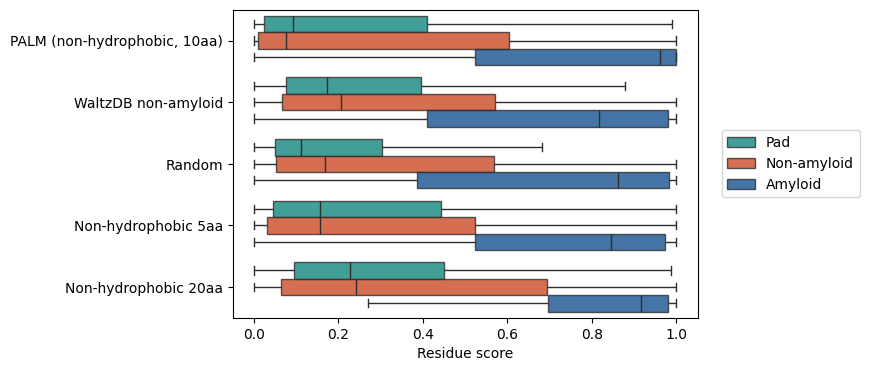

In [12]:
fig = plt.figure(figsize=(6,4))
sns.boxplot(data=results,x='Residue score',y='dataset',hue='Residue type',fliersize=0, palette=[lacroix.colorList('Lemon')[3],lacroix.colorList('PeachPear')[0],lacroix.colorList('Lime')[4]], boxprops=dict(alpha=0.8))
plt.ylabel('')

plt.legend(fontsize=10, loc='center', bbox_to_anchor=(0, 0, 2.4, 1))

fig.savefig('/novo/projects/departments/cdd/public/users/ehec/au24/plotting_for_paper/2506_figures_final/supp_resbox.png', dpi=600, bbox_inches='tight')
fig.savefig('/novo/projects/departments/cdd/public/users/ehec/au24/plotting_for_paper/2506_figures_final/supp_resbox.pdf', dpi=600, bbox_inches='tight')
plt.show()